In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import torch
torch.cuda.is_available()

True

### Load data

In [3]:
new_gapn_data_file = "data/20211018-GapN-data-up-to-SM160.csv"
data = pd.read_csv(new_gapn_data_file, index_col=0)
# data = data.dropna()
# drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
data['Sequence'] = data['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', '').strip('*'))
data.index = data.index.str.strip('p')

In [4]:
data.head(2)

,Sequence,WT_mutations,NAD+_initial_rate,NADP+_initial_rate
WT,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,NaN,0.17667,41.342222
SM038,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,G209V,0.80667,39.055556


#### Make sure sequences match mutation annotation 

In [5]:
seq_list = data.Sequence.apply(list).apply(np.asarray)
mutations = seq_list.apply(lambda x: [f"{seq_list[0][i]}{i}{x[i]}" for i in np.where(seq_list[0] != x)[0]])
data['mutation_from_seq'] = mutations.apply(set)
data['mutation_from_annot'] = data.WT_mutations.fillna('').str.split(' \+ ')\
    .apply(lambda x: [xi.strip().rstrip() for xi in x]).apply(set)

data[data.mutation_from_seq != data.mutation_from_annot].iloc[:, -2:]

,mutation_from_seq,mutation_from_annot
WT,{},{}


### Load MSA 

In [6]:
# copied from here: https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

In [7]:
# msa_data = read_msa("data/msa/gapn_hhblits_default_settings.a3m", 250)
# the large MSA is not fitting onto GPU memory. Try with a smaller MSA
msa_data = read_msa("data/msa/gapn_hhblits_default_settings.a3m", 30)

### Calculate Embeddings

In [8]:
import sys
sys.path.insert(0,'/projects/bpms/jlaw')
import esm

In [9]:
model_name = "esm_msa1b_t12_100M_UR50S"
torch.hub.set_dir('/scratch/jlaw/torch')
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main


In [10]:
model = model.eval().cuda()
msa_batch_converter = alphabet.get_batch_converter()

In [11]:
batch_labels, batch_strs, batch_tokens = msa_batch_converter([msa_data])
batch_tokens = batch_tokens.cuda()
print(batch_tokens.size(), batch_tokens.dtype)  # Should be a 3D tensor with dtype torch.int64.

torch.Size([1, 30, 476]) torch.int64


## Predict the effects of mutations

In [11]:
def calculate_likelihoods(msa_data, data):
    # for each mutated sequence, use it as the WT within the MSA
    mut_msa_data = [[(seq_id, seq)] + msa_data[1:] for seq_id, seq in data['Sequence'].items()]
    batch_labels, batch_strs, batch_tokens = msa_batch_converter(mut_msa_data)
    batch_dataloader = torch.utils.data.DataLoader(batch_tokens, batch_size=1)

    output = []
    with torch.no_grad():
        for batch in tqdm(batch_dataloader, leave=False):
            batch_cuda = batch.cuda()
            token_probs = torch.log_softmax(model(batch_cuda)["logits"], dim=-1)
            gathered_probs = torch.gather(token_probs.cpu(), 2, batch.unsqueeze(-1)).squeeze()
            # keep only the first sequence
            gathered_probs = gathered_probs[0, :].cpu().numpy()
            output.append(gathered_probs)

    output = np.asarray(output)
    return output

### Mean of 5 randomly sampled MSAs of size 32

In [13]:
# try pooling results from multiple subsets of MSAs 
msa_data = read_msa("data/msa/gapn_hhblits_default_settings.a3m", 250)
outputs = []
for i in trange(5):
    # the first sequence is the WT, then select the other sequences in the MSA at random
    curr_msa_data = [msa_data[0]] + [msa_data[j] for j in np.random.randint(1, 250, size=31)]
    output = calculate_likelihoods(msa_data, data)
    outputs.append(output)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

In [14]:
outputs = np.array(outputs)

<AxesSubplot:>

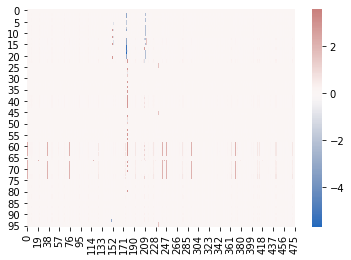

In [16]:
normed_likelihood = (outputs - outputs[:, [0], :])
sns.heatmap(normed_likelihood.mean(0), cmap='vlag', center=0)

In [17]:
data['mutation'] = data.mutation_from_annot.apply(list)
data_explode = data.explode('mutation')

In [18]:
mutation_counts = data_explode.mutation.value_counts().drop('')
data_subset = data_explode[data_explode.mutation.isin(mutation_counts[mutation_counts >= 1].index)]

In [19]:
lh = pd.DataFrame(normed_likelihood.sum(2).mean(0), index=data.index, columns=['value'])
lh['mutation'] = data['mutation']
lh_explode = lh.explode('mutation')

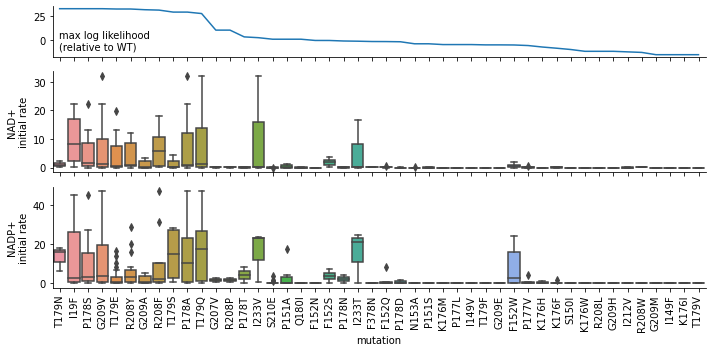

In [21]:
fig, axs = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 2, 2]}, sharex=True, figsize=(10, 5))

# x_order = data_subset.groupby('mutation').max().sort_values('NAD+_initial_rate', ascending=False).index
x_order = lh_explode.groupby('mutation').value.max().sort_values(ascending=False).drop('').index

sns.boxplot(data=data_explode, x='mutation', y='NAD+_initial_rate',
            order=x_order, ax=axs[1])

sns.boxplot(data=data_explode, x='mutation', y='NADP+_initial_rate',
            order=x_order, ax=axs[2])

axs[1].set_ylabel('NAD+\ninitial rate')
axs[2].set_ylabel('NADP+\ninitial rate')

axs[0].plot(np.arange(len(x_order)), lh_explode.groupby('mutation').value.max().reindex(x_order).values.squeeze())
axs[0].text(0.01, 0.1, 'max log likelihood\n(relative to WT)', ha='left', va='bottom', transform=axs[0].transAxes)

axs[1].set_xlabel(None)

_ = axs[-1].set_xticklabels(axs[-1].get_xticklabels(), rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig('esm_msa1b_vs_activity.svg')

In [22]:
data['log_likelihood'] = normed_likelihood.sum(2).mean(0)

Text(0, 0.5, 'initial rate')

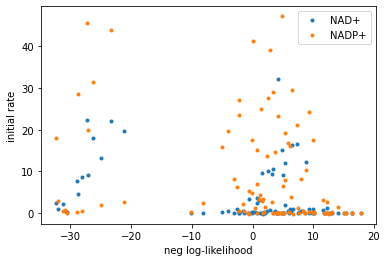

In [23]:
plt.plot(-data.log_likelihood, data['NAD+_initial_rate'], '.', label='NAD+')
plt.plot(-data.log_likelihood, data['NADP+_initial_rate'], '.', label='NADP+')
plt.legend(loc='upper right')
plt.xlabel('neg log-likelihood')
plt.ylabel('initial rate')

### MSA of first 30 sequences

<AxesSubplot:>

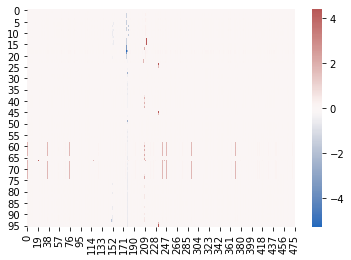

In [33]:
normed_likelihood = (output - output[0, :])
sns.heatmap(normed_likelihood, cmap='vlag', center=0)

In [34]:
data['log_likelihood'] = normed_likelihood.sum(1)

In [44]:
normed_likelihood

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03479004,  0.00125694,  0.01040649, ..., -0.00260353,
         0.02226639, -0.00393105],
       [-0.06214523,  0.00280762,  0.02163887, ...,  0.00175285,
         0.01955605, -0.00707245],
       ...,
       [-0.36154747,  0.09483337,  0.02244949, ...,  0.00850677,
         0.03444481,  0.00177383],
       [-0.11129951,  0.02697563, -0.00920868, ...,  0.00408363,
        -0.01122284,  0.0010643 ],
       [-0.10554123,  0.01875114, -0.00445747, ...,  0.01288033,
        -0.01591492, -0.00119209]], dtype=float32)

Text(0, 0.5, 'initial rate')

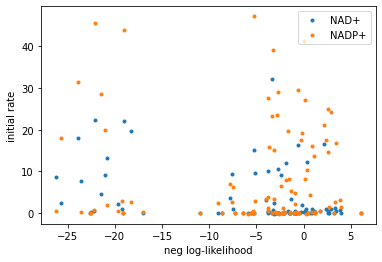

In [35]:
plt.plot(-data.log_likelihood, data['NAD+_initial_rate'], '.', label='NAD+')
plt.plot(-data.log_likelihood, data['NADP+_initial_rate'], '.', label='NADP+')
plt.legend(loc='upper right')
plt.xlabel('neg log-likelihood')
plt.ylabel('initial rate')

In [45]:
data['mutation'] = data.mutation_from_annot.apply(list)
data_explode = data.explode('mutation')

In [46]:
mutation_counts = data_explode.mutation.value_counts().drop('')
data_subset = data_explode[data_explode.mutation.isin(mutation_counts[mutation_counts >= 1].index)]

In [48]:
lh = pd.DataFrame(normed_likelihood.sum(1), index=data.index, columns=['value'])
lh['mutation'] = data['mutation']
lh_explode = lh.explode('mutation')

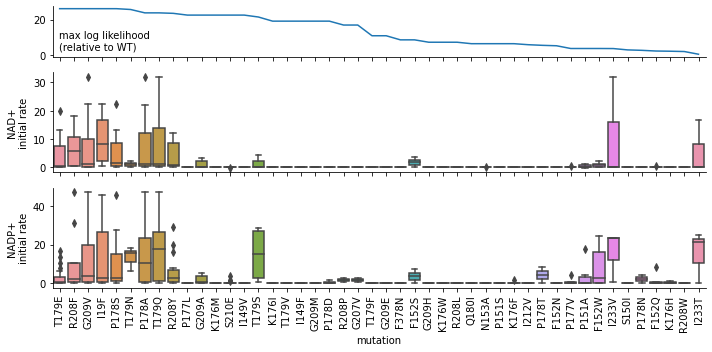

In [49]:
fig, axs = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 2, 2]}, sharex=True, figsize=(10, 5))

# x_order = data_subset.groupby('mutation').max().sort_values('NAD+_initial_rate', ascending=False).index
x_order = lh_explode.groupby('mutation').value.max().sort_values(ascending=False).drop('').index

sns.boxplot(data=data_explode, x='mutation', y='NAD+_initial_rate',
            order=x_order, ax=axs[1])

sns.boxplot(data=data_explode, x='mutation', y='NADP+_initial_rate',
            order=x_order, ax=axs[2])

axs[1].set_ylabel('NAD+\ninitial rate')
axs[2].set_ylabel('NADP+\ninitial rate')

axs[0].plot(np.arange(len(x_order)), lh_explode.groupby('mutation').value.max().reindex(x_order).values.squeeze())
axs[0].text(0.01, 0.1, 'max log likelihood\n(relative to WT)', ha='left', va='bottom', transform=axs[0].transAxes)

axs[1].set_xlabel(None)

_ = axs[-1].set_xticklabels(axs[-1].get_xticklabels(), rotation=90)

sns.despine()
plt.tight_layout()
# plt.savefig('esm1v_vs_activity.svg')

### Approach used in esm1v paper
https://github.com/facebookresearch/esm/tree/main/variant-prediction

The code they provide only considers one mutation position at a time. Since we have up to 6 positions mutated, we want to consider the effect of all of those mutations on the sequence embedding.

In [14]:
def label_row(row, sequence, token_probs, alphabet, offset_idx):
    wt, idx, mt = row[0], int(row[1:-1]) - offset_idx, row[-1]
    assert sequence[idx] == wt, "The listed wildtype does not match the provided sequence"

    wt_encoded, mt_encoded = alphabet.get_idx(wt), alphabet.get_idx(mt)

    # add 1 for BOS
    score = token_probs[0, 1 + idx, mt_encoded] - token_probs[0, 1 + idx, wt_encoded]
    return score.item()

In [30]:
# use the masked marginals approach
# "MSA Transformer only supports masked marginal strategy"

all_token_probs = []
for i in tqdm(range(batch_tokens.size(2))):
    batch_tokens_masked = batch_tokens.clone()
    batch_tokens_masked[0, 0, i] = alphabet.mask_idx  # mask out first sequence
    with torch.no_grad():
        token_probs = torch.log_softmax(
            model(batch_tokens_masked.cuda())["logits"], dim=-1
        )
    all_token_probs.append(token_probs[:, 0, i])  # vocab size
token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)

  0%|          | 0/476 [00:00<?, ?it/s]

In [24]:
alphabet.get_idx('M')

20

In [26]:
token_probs.shape

torch.Size([1, 476, 33])

### Predict contacts

In [13]:
msa_contacts = model.predict_contacts(msa_batch_tokens).cpu()

In [15]:
msa_contacts.detach().numpy()

array([[[0.06772016, 0.13622297, 0.12105578, ..., 0.00804226,
         0.01024682, 0.05550207],
        [0.13622297, 0.01781718, 0.12449987, ..., 0.0083001 ,
         0.01115957, 0.08424085],
        [0.12105578, 0.12449987, 0.01472028, ..., 0.00772496,
         0.01156092, 0.03311186],
        ...,
        [0.00804226, 0.0083001 , 0.00772496, ..., 0.01299056,
         0.03319496, 0.5864979 ],
        [0.01024682, 0.01115958, 0.01156092, ..., 0.03319496,
         0.04216506, 0.4786834 ],
        [0.05550207, 0.08424085, 0.03311186, ..., 0.5864979 ,
         0.4786834 , 0.30417123]]], dtype=float32)

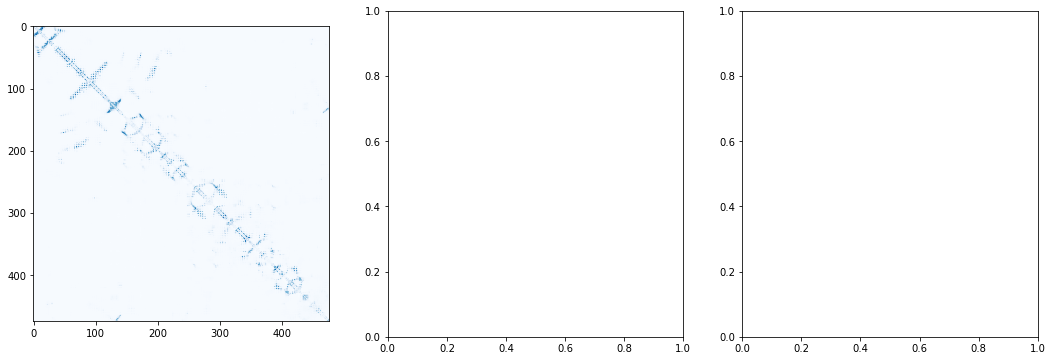

In [16]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, msa in zip(axes, msa_contacts.detach().numpy(), msa_batch_strs):
    seqlen = len(msa[0])
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()

In [ ]:
msa_transformer, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_batch_converter = msa_alphabet.get_batch_converter()